##GAN&CLIP - WITH CALLBACKS

See how the model is training...

Overview:
This notebook is handling the pipeline of 


Authors: Maciej Domagała, Adam Komorowski

### GENERATING IMAGES

In [12]:
#@title Initialization (Installation, Imports) - check github branch!
%%capture
import subprocess
import re

nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
version = re.findall("release (\d+\.\d+)", nvcc)[0]

pytorch_suffix = {
    "10.0": "+cu100",
    "10.1": "+cu101",
    "10.2": "",
}

pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt #imagenet_classes

!git clone https://github.com/maciejdomagala/clip_gans.git
%cd clip_gans
!git checkout main ### WARNING!!!

try:
  import torch
except:
  !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

try:
  import torchvision
except:
  !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

!pip install pytorch_pretrained_biggan pymoo kornia ftfy tensorboard

# IMPORTS
import warnings

import argparse
import os
import torch
import numpy as np
import pickle
import math
from tqdm import tqdm_notebook
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request
import cv2

from config import get_config
from problem import GenerationProblem
from operators import get_operators
from operators import get_algo


warnings.filterwarnings('ignore')

In [13]:
#@title Input Parameters
target = "a white cat on a beach" #@param {type:"string"}
config = "StyleGAN2_cat_de" #@param ["DeepMindBigGAN256_ga","DeepMindBigGAN256_de", "StyleGAN2_ffhq_ga","StyleGAN2_ffhq_de", "StyleGAN2_car_ga", "StyleGAN2_car_de","StyleGAN2_church_ga", "StyleGAN2_church_de","StyleGAN2_cat_ga", "StyleGAN2_cat_de"]
generations =   200#@param {type:"number"}
callbacks_each =  10 #@param {type: "number"}
population_size =  16#@param {type:"number"}
#number_of_loops =  1 #@param {type:"number"}
# algorithm_param = 'ga' #@param ['ga', 'de']

In [14]:
#@title Download weights for given model
!chmod +x ./download-weights.sh
if "ffhq" in config:
  ! ./download-weights.sh StyleGAN2-ffhq
if "church" in config:
  ! ./download-weights.sh StyleGAN2-church
if "car" in config:
  ! ./download-weights.sh StyleGAN2-car
if "cat" in config:
  ! ./download-weights.sh StyleGAN2-cat

Converting tensorflow models and saving them...
Done!


In [15]:
#@title Config 
config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    tmp_folder="./results"
)
vars(config).update(get_config(config.config))
config.pop_size = population_size
# config.algorithm = algorithm_param
config.generations = generations
config.callbacks_each = callbacks_each

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)
if not os.path.exists(f'{config.tmp_folder}/{config.target}'): os.mkdir(f'{config.tmp_folder}/{config.target}')


In [16]:
#@title Support methods
def callback(algorithm):
    global config, iteration, loop, target

    iteration += 1

    sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
    X = np.stack([p.X for p in sortedpop])      
    ls = config.latent(config)
    ls.set_from_population(X)
    if (iteration%config.callbacks_each == 0) or (iteration==config.generations):
      with torch.no_grad():
        generated = algorithm.problem.generator.generate(ls)
        name = f'batch_iteration_{iteration}.jpg'
        algorithm.problem.generator.save(generated, f"./{config.tmp_folder}/{config.target}/{name}")
        print(f'After {iteration} iterations...')
        display(Image(f"./{config.tmp_folder}/{config.target}/{name}"))

def generate_image(loop: int):
  problem = GenerationProblem(config)

  kwargs = get_algo(config)

  algorithm = get_algorithm(
      config.algorithm,
      callback=callback,
      **kwargs
  )

  res = minimize(
      problem,
      algorithm,
      ("n_gen", config.generations),
      save_history=False,
      verbose=True,
  )


  X = np.atleast_2d(res.X)
  ls = config.latent(config)
  ls.set_from_population(X)

  with torch.no_grad():
      generated = problem.generator.generate(ls)
  print(f'Final image for "{config.target}" target.')
  problem.generator.save(generated, f"./{config.tmp_folder}/{config.target}/final.jpg")
  display(Image(f"./{config.tmp_folder}/{config.target}/final.jpg"))

n_gen |  n_eval |   cv (min)   |   cv (avg)   |     fopt     |     favg    
    1 |      16 |  0.00000E+00 |  0.00000E+00 |       -0.279 |      -0.2235
    2 |      32 |  0.00000E+00 |  0.00000E+00 |       -0.279 |      -0.2345
    3 |      48 |  0.00000E+00 |  0.00000E+00 |       -0.279 |      -0.2418
    4 |      64 |  0.00000E+00 |  0.00000E+00 |       -0.279 |       -0.246
    5 |      80 |  0.00000E+00 |  0.00000E+00 |       -0.281 |       -0.253
    6 |      96 |  0.00000E+00 |  0.00000E+00 |       -0.281 |      -0.2585
    7 |     112 |  0.00000E+00 |  0.00000E+00 |      -0.3386 |      -0.2651
    8 |     128 |  0.00000E+00 |  0.00000E+00 |      -0.3386 |      -0.2686
    9 |     144 |  0.00000E+00 |  0.00000E+00 |      -0.3386 |      -0.2727
   10 |     160 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.2769
After 10 iterations...


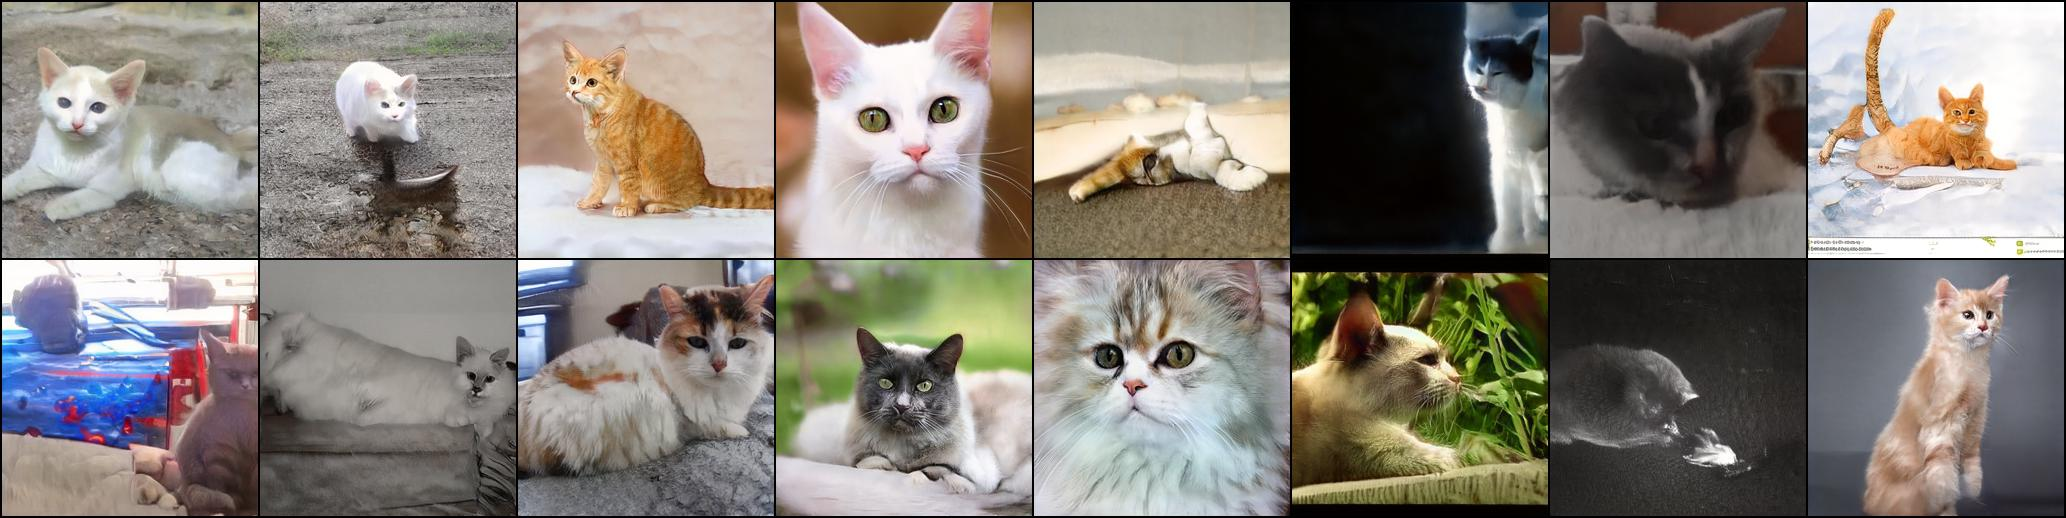

   11 |     176 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |        -0.28
   12 |     192 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |        -0.28
   13 |     208 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.2808
   14 |     224 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.2864
   15 |     240 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.2869
   16 |     256 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |        -0.29
   17 |     272 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |        -0.29
   18 |     288 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.2903
   19 |     304 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |       -0.292
   20 |     320 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.2922
After 20 iterations...


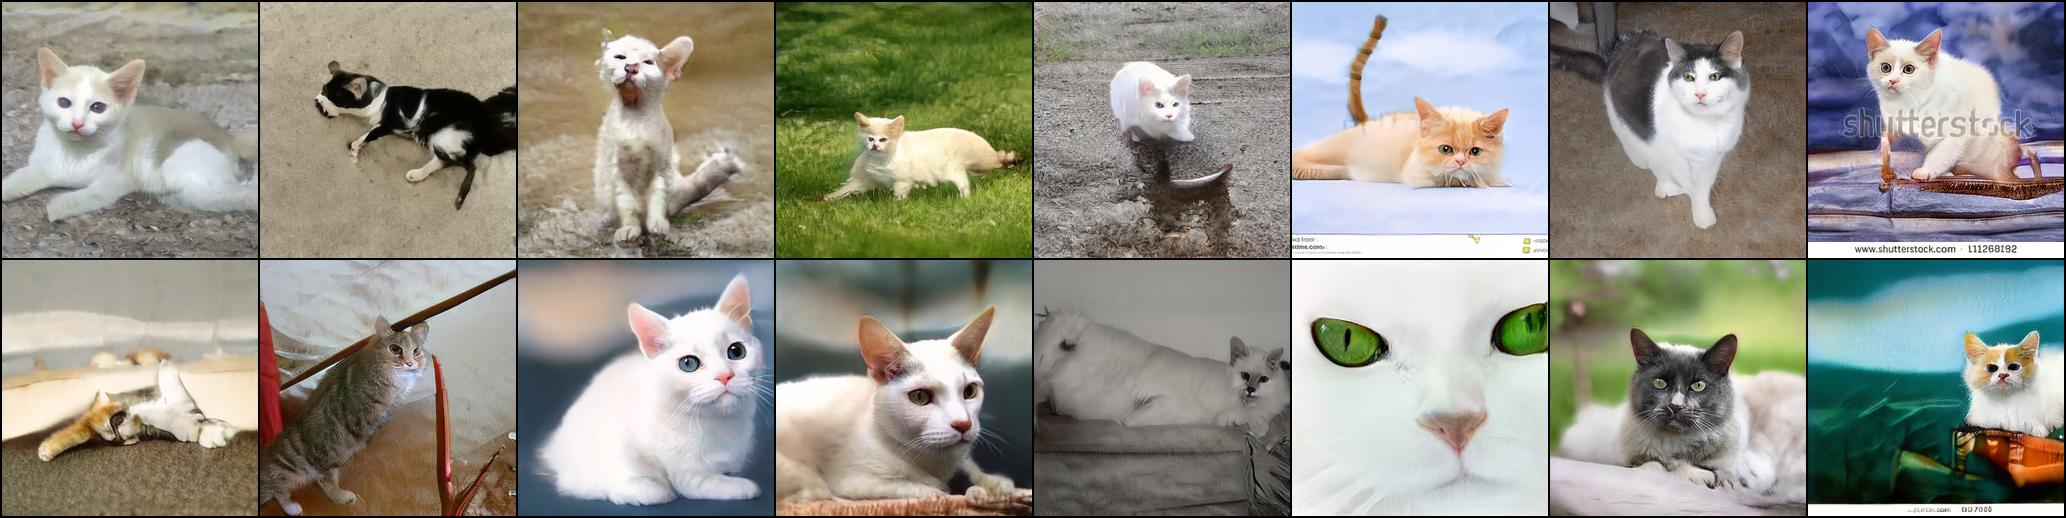

   21 |     336 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.2922
   22 |     352 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.2925
   23 |     368 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.2969
   24 |     384 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |         -0.3
   25 |     400 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.3022
   26 |     416 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.3022
   27 |     432 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |       -0.303
   28 |     448 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |       -0.304
   29 |     464 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.3042
   30 |     480 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |       -0.308
After 30 iterations...


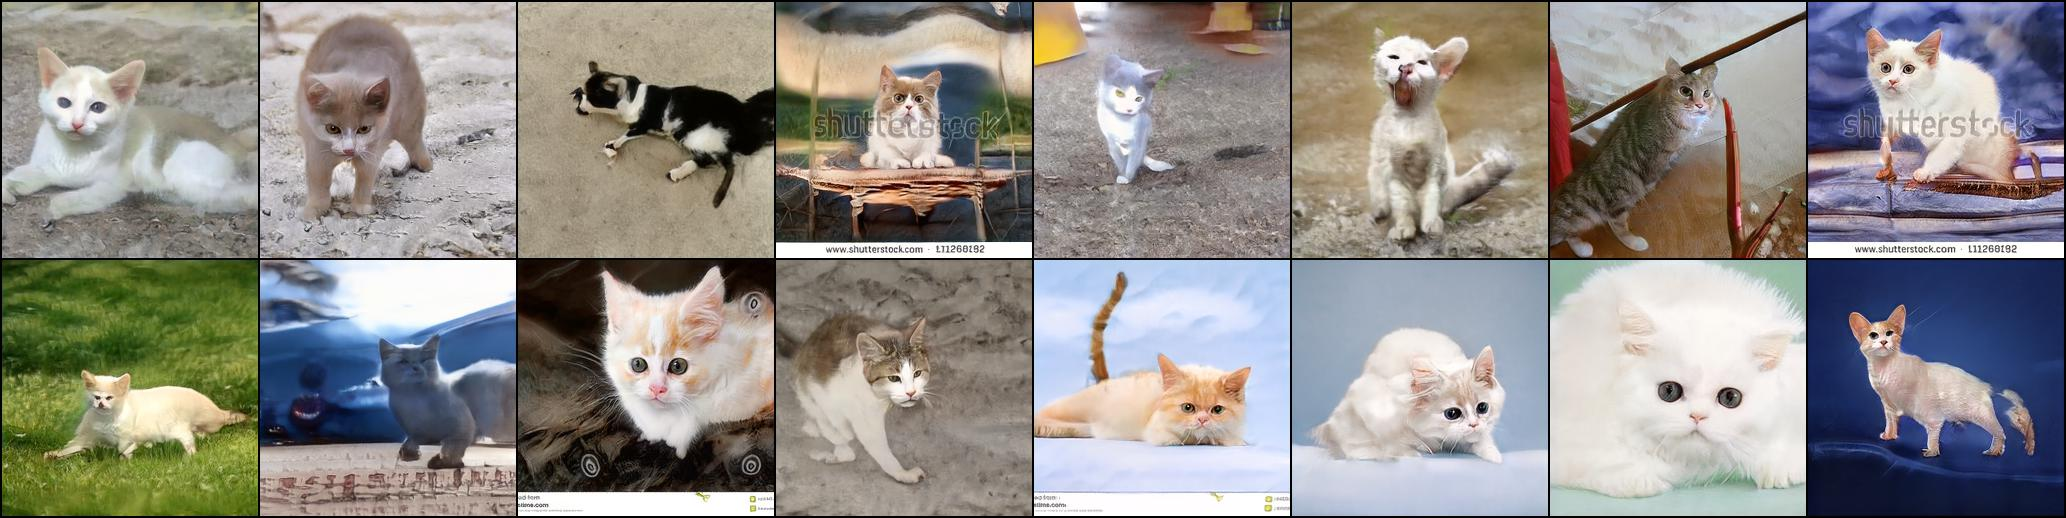

   31 |     496 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.3088
   32 |     512 |  0.00000E+00 |  0.00000E+00 |      -0.3533 |      -0.3088
   33 |     528 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |       -0.309
   34 |     544 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3093
   35 |     560 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3096
   36 |     576 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3108
   37 |     592 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3135
   38 |     608 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3137
   39 |     624 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3164
   40 |     640 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3184
After 40 iterations...


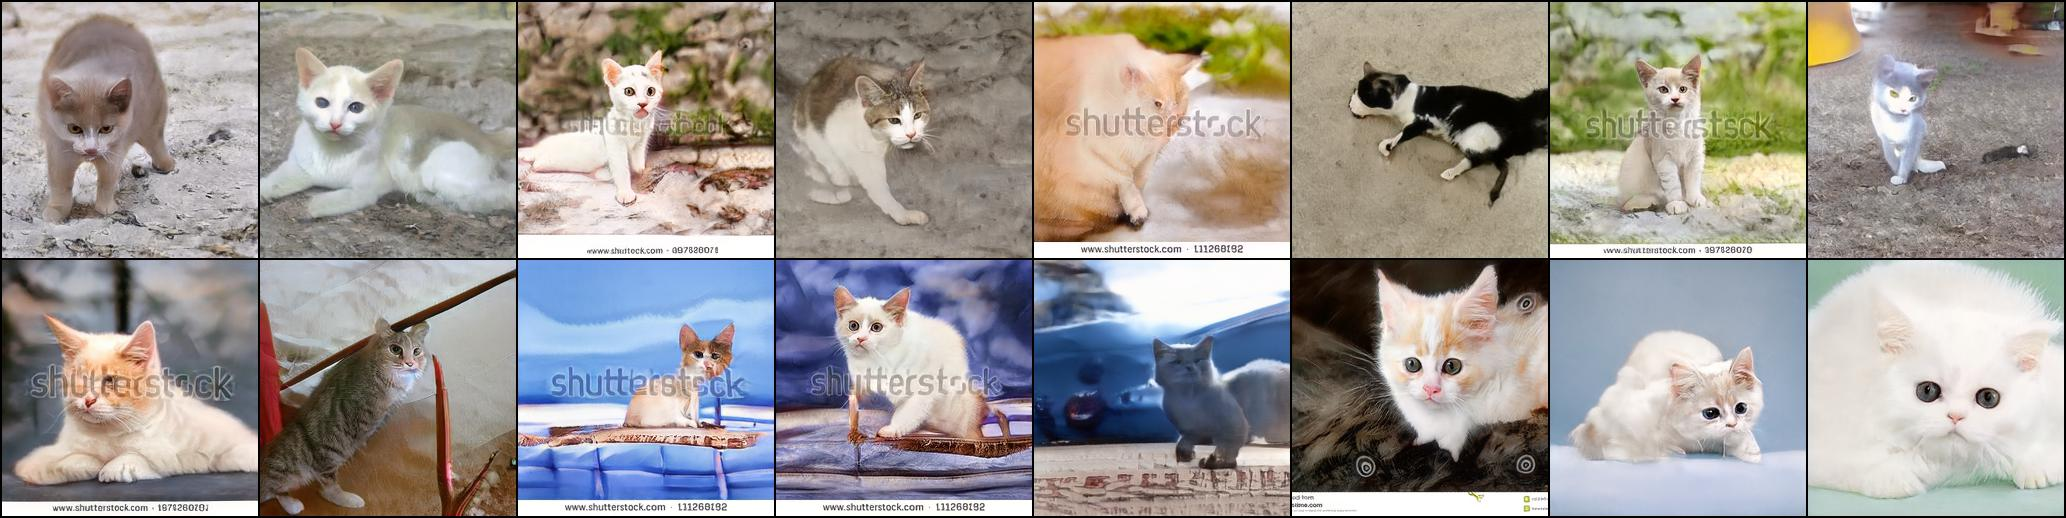

   41 |     656 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |       -0.319
   42 |     672 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3196
   43 |     688 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3232
   44 |     704 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3245
   45 |     720 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3245
   46 |     736 |  0.00000E+00 |  0.00000E+00 |       -0.368 |       -0.325
   47 |     752 |  0.00000E+00 |  0.00000E+00 |       -0.368 |       -0.325
   48 |     768 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3257
   49 |     784 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3267
   50 |     800 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3274
After 50 iterations...


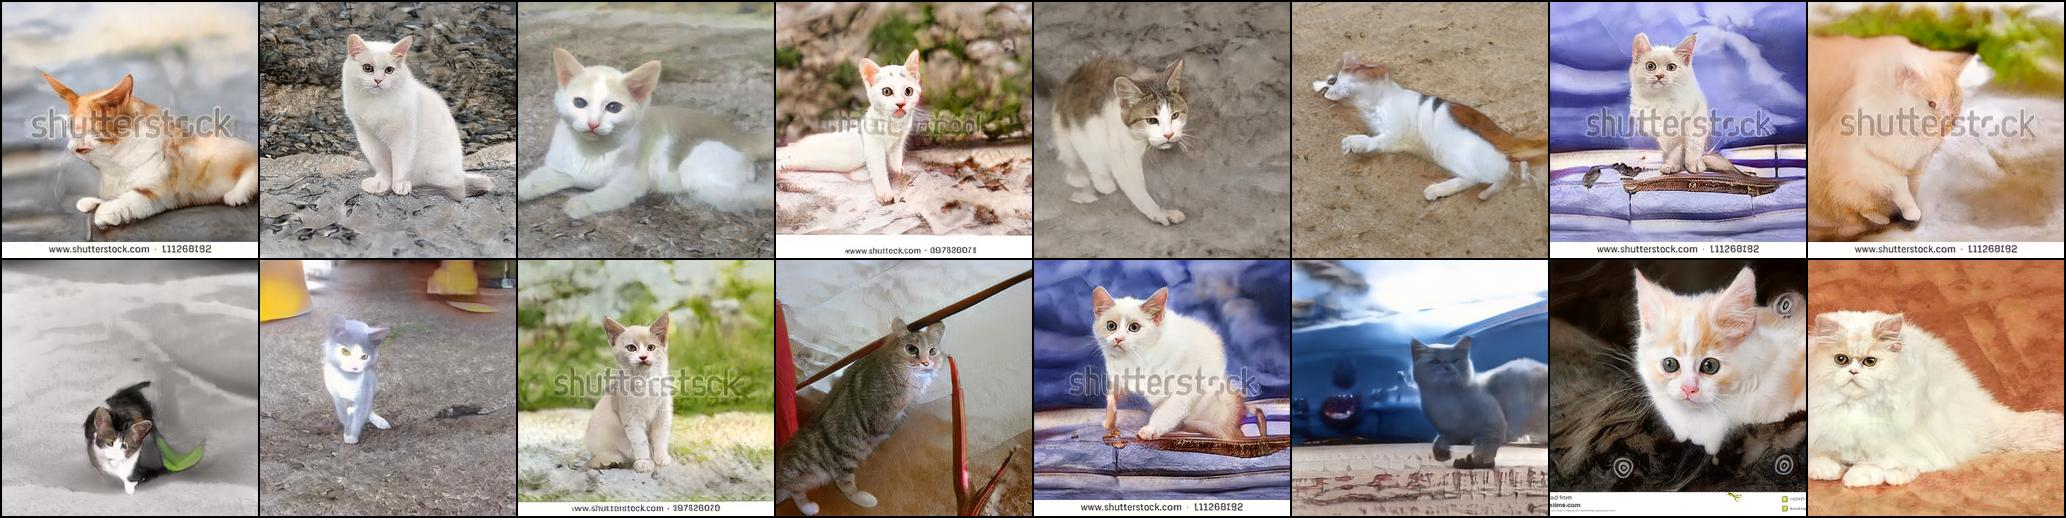

   51 |     816 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3284
   52 |     832 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3284
   53 |     848 |  0.00000E+00 |  0.00000E+00 |       -0.368 |        -0.33
   54 |     864 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3306
   55 |     880 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3315
   56 |     896 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3325
   57 |     912 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3325
   58 |     928 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3325
   59 |     944 |  0.00000E+00 |  0.00000E+00 |       -0.368 |       -0.333
   60 |     960 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3335
After 60 iterations...


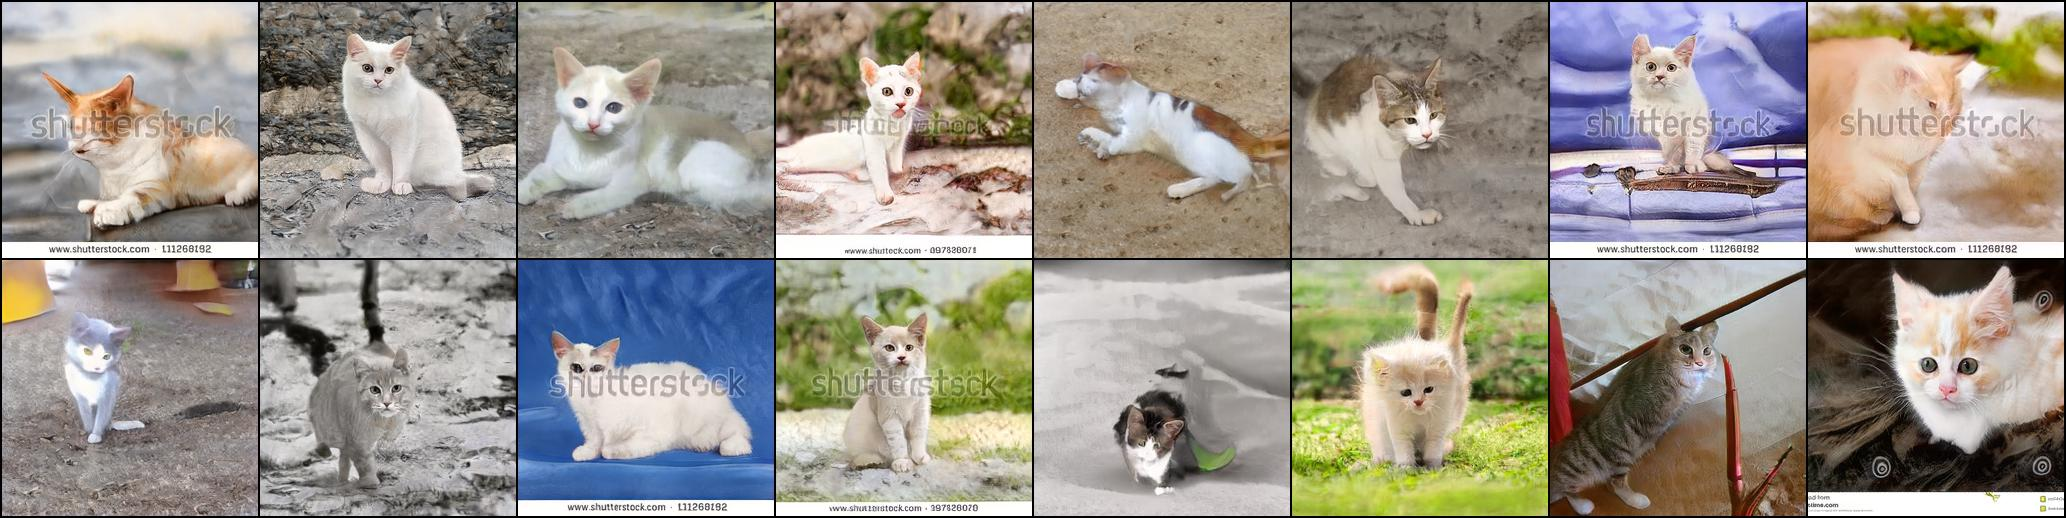

   61 |     976 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3342
   62 |     992 |  0.00000E+00 |  0.00000E+00 |       -0.368 |       -0.335
   63 |    1008 |  0.00000E+00 |  0.00000E+00 |       -0.368 |       -0.335
   64 |    1024 |  0.00000E+00 |  0.00000E+00 |       -0.368 |       -0.335
   65 |    1040 |  0.00000E+00 |  0.00000E+00 |       -0.368 |      -0.3374
   66 |    1056 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3384
   67 |    1072 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3386
   68 |    1088 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3386
   69 |    1104 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3394
   70 |    1120 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3394
After 70 iterations...


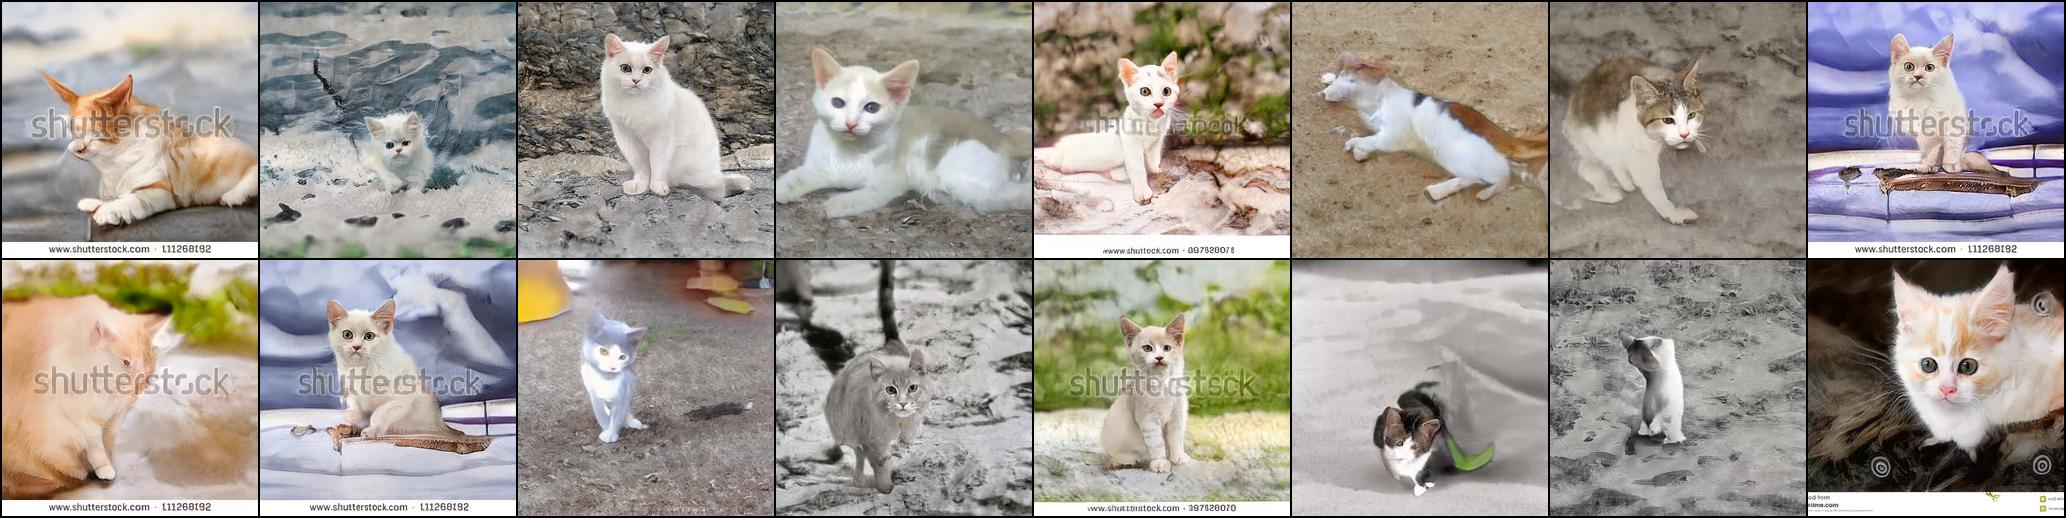

   71 |    1136 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3394
   72 |    1152 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3394
   73 |    1168 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |       -0.341
   74 |    1184 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3425
   75 |    1200 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3425
   76 |    1216 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3425
   77 |    1232 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3425
   78 |    1248 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3425
   79 |    1264 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3425
   80 |    1280 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3425
After 80 iterations...


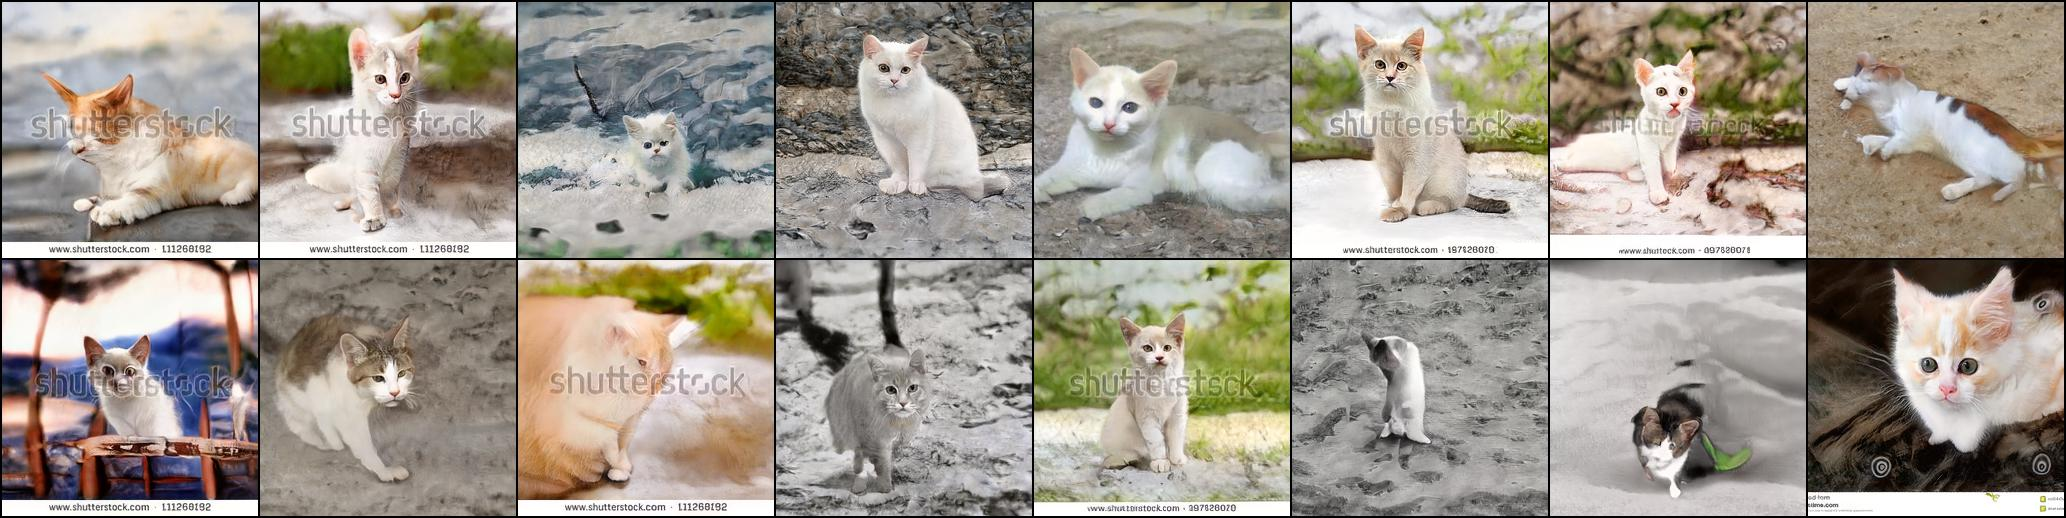

   81 |    1296 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3425
   82 |    1312 |  0.00000E+00 |  0.00000E+00 |      -0.3838 |      -0.3433


In [ ]:
 #@title RUN (GENERATE IMAGES)

iteration=0
generate_image(0)